# Colon Polyp Classification using FastAI


In 2018, I published a github repository **CNN4Polyps** about colonoscopy polyps detection (classification + localization into an image)  with CNNs (https://github.com/muntisa/Colonoscopy-polyps-detection-with-CNNs) using *Keras*. I demonstrated that simple CNNs or transfer learning could be used in only few minutes (on a GPU) to create good classifiers able to detect a polyp in colonoscopy images.

Reading twitts these days, I found a great presentation of *Jeremy Howard* about "Future of Individualized Medicine 2019" (https://twitter.com/jeremyphoward/status/1112810731773190144). During the presentation, I was suprized to find that on [Modelzoo](https://modelzoo.co/category/computer-vision) there is no shared pre-trained network even if there are a lot of public medical imaging dataset and easy tools for DL such as Fastai & Colab. Therefore, I decide to spend one hour to adapt the **Fast.ai** Lesson 1 notebook (https://course.fast.ai/videos/?lesson=1) for my dataset. To be faster, I used Google Colab (https://colab.research.google.com) with GPU support.

The current dataset was generated with the previous project [CNN4Polyps](https://github.com/muntisa/Colonoscopy-polyps-detection-with-CNNs) starting from a public datase: 910 images for training and 302 images for validation. All the models are saved in the project root, so you can easy load them and test your data.

The current script demonstrated the ability to create a very accurate classifier for medical imaging with an accuracy of 0.99 using transfer learning from *resnet50*. 

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

I used preinstalled fastai and pytorch from colab:

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

I connected the dataset from my google drive to colab. If you will have the dataset on gdrive, you will need to authorize a link:

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now I have *My Drive* with the project folder and I will save it as *path* variable. If you have the dataset into another location, please change the path.

In [4]:
path = "/content/drive/My Drive/myAI-Projects/Colonoscopy-polyps-detection-with-CNNs/data_polyps"
path

'/content/drive/My Drive/myAI-Projects/Colonoscopy-polyps-detection-with-CNNs/data_polyps'

I used the same 64 for the batch size during the training.

In [0]:
np.random.seed(2)
bs= 32
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

I change the original function to get data from one folder and the labels from the name of the file with the function that is able to get data from a folder. You need to have at least two subfolders: *train* and *valid* (not validation!). In each subfolder, you will have one folder for each class. So, I have *non_polyps* and *polyps* subfolders in *train* and *valid* folders.

In [0]:
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)

## Looking at the data

Let's see few images:

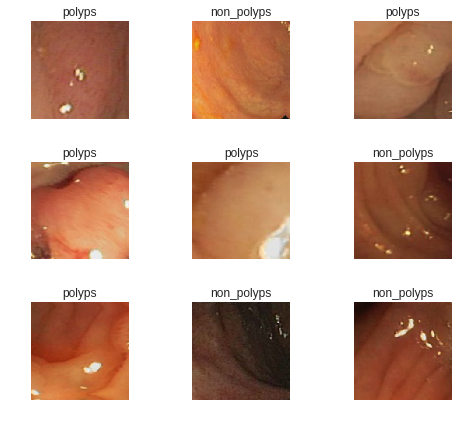

In [7]:
data.show_batch(rows=3, figsize=(7,6))

Let's check the number of classes extracted from folders:

In [8]:
print(data.classes)
len(data.classes),data.c

['non_polyps', 'polyps']


(2, 2)

## Training: resnet34

The first test was done with *resnet34* transfer learning.  It's a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. So, let's create a learner based on *resnet34*. This step will download the pre-trained networks.

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy])

Let's fit for the first time our data in only 5 epochs. Please, remember that we are training only the fully connected part of the network and the convolutional blocks are freezed (transfer learning).

In [19]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.699072,0.330484,0.847682,00:17
1,0.509559,0.273260,0.887417,00:17
2,0.451120,0.217978,0.913907,00:17
3,0.422313,0.211415,0.927152,00:17
4,0.377554,0.199659,0.933775,00:17


We obtain an accuracy (ACC) of 0.9337 in less than 1.5 minutes! So, we save this network as *polyp-resnet34* in the project folder:

In [0]:
learn.save(path+'/polyp-resnet34_ACC-0.9337')

## Results

In this section, we interpret the classifier by showing the worst errrors and the confusion matrix.

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

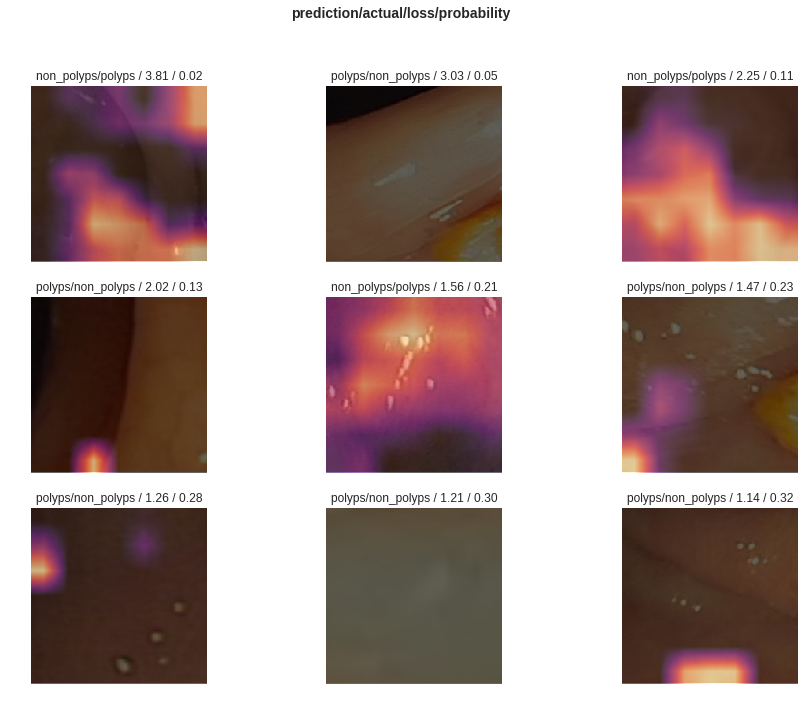

In [22]:
interp.plot_top_losses(9, figsize=(15,11))

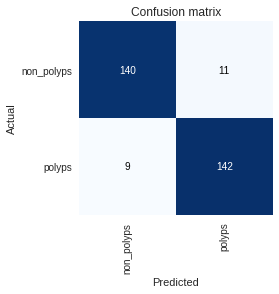

In [23]:
interp.plot_confusion_matrix()

In [24]:
interp.most_confused()

[('non_polyps', 'polyps', 11), ('polyps', 'non_polyps', 9)]

## Unfreezing, fine-tuning, and learning rates

We will try more advanced training  and we will *unfreeze* our model. So, it will start with the previous trained network and it will apply an extra training in all the layers.

In [0]:
learn.unfreeze()

In [26]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.296586,0.234009,0.897351,00:19
1,0.324419,0.354235,0.874172,00:18
2,0.292737,0.172140,0.923841,00:18
3,0.243233,0.126022,0.950331,00:18
4,0.188972,0.117068,0.956954,00:18


Using fine-tuning with default learning rate for *resnet34*, it's possible to obtain in less than 2 minutes **ACC = 0.957**!

In [0]:
learn.save(path+'/polyp-resnet34_fine-tuning_ACC-0.9569')

In [28]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.109072,0.093588,0.966887,00:18
1,0.128473,0.145218,0.963576,00:18
2,0.160673,0.212688,0.923841,00:18
3,0.190799,0.215548,0.923841,00:18
4,0.181920,0.134736,0.956954,00:18
5,0.183510,0.170171,0.923841,00:18
6,0.156675,0.109344,0.953642,00:19
7,0.125457,0.088489,0.966887,00:18
8,0.105464,0.057637,0.980132,00:18
9,0.084103,0.058488,0.980132,00:18


In [0]:
learn.save(path+'/polyp-resnet34_fine-tuning_ACC-0.98')

So, even with the default learning rate we are able to obtain an **ACC = 0.98** for *resnet34 fine tunning*!

Maybe we should try to find a better learning rate:

In [30]:
learn.load(path+'/polyp-resnet34_ACC-0.9337')

Learner(data=ImageDataBunch;

Train: LabelList (910 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
non_polyps,non_polyps,non_polyps,non_polyps,non_polyps
Path: /content/drive/My Drive/myAI-Projects/Colonoscopy-polyps-detection-with-CNNs/data_polyps;

Valid: LabelList (302 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
non_polyps,non_polyps,non_polyps,non_polyps,non_polyps
Path: /content/drive/My Drive/myAI-Projects/Colonoscopy-polyps-detection-with-CNNs/data_polyps;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


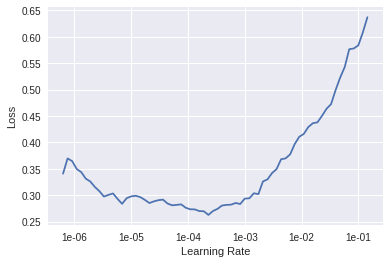

In [32]:
learn.recorder.plot()

So, I tried two different learning rates for different layers:

In [39]:
learn.load(path+'/polyp-resnet34_ACC-0.9337')
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-6,4e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.327130,0.189254,0.933775,00:17
1,0.292592,0.159413,0.947020,00:17
2,0.276428,0.156669,0.943709,00:17
3,0.255049,0.130724,0.963576,00:18
4,0.246588,0.129857,0.963576,00:17


Extra training:

In [40]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,4e-4/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.193217,0.129875,0.963576,00:17
1,0.198871,0.124246,0.963576,00:17
2,0.194375,0.127652,0.963576,00:17
3,0.180465,0.124842,0.956954,00:17
4,0.174252,0.114450,0.956954,00:18
5,0.174385,0.109703,0.963576,00:17
6,0.157331,0.104867,0.963576,00:17
7,0.159101,0.105668,0.963576,00:16
8,0.160479,0.102118,0.966887,00:16
9,0.155408,0.104169,0.960265,00:17


In [41]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,4e-4/2))

epoch,train_loss,valid_loss,accuracy,time
0,0.148632,0.103387,0.963576,00:17
1,0.150573,0.098865,0.966887,00:17
2,0.160477,0.098355,0.966887,00:16
3,0.156485,0.094962,0.970199,00:16
4,0.147030,0.091759,0.966887,00:16
5,0.136681,0.085471,0.966887,00:17
6,0.120174,0.089444,0.960265,00:17
7,0.105960,0.089041,0.963576,00:16
8,0.110758,0.094643,0.970199,00:16
9,0.107981,0.089981,0.970199,00:16


In [42]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,4e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.118315,0.089410,0.970199,00:17
1,0.113396,0.099689,0.966887,00:17
2,0.109575,0.091476,0.966887,00:17
3,0.109048,0.075518,0.976821,00:17
4,0.102424,0.079879,0.973510,00:16
5,0.094266,0.074652,0.976821,00:16
6,0.089199,0.076106,0.970199,00:16
7,0.085841,0.072925,0.976821,00:17
8,0.083385,0.076599,0.973510,00:16
9,0.082169,0.074601,0.973510,00:16


In [43]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.078509,0.071628,0.973510,00:17
1,0.081900,0.069290,0.976821,00:17
2,0.079350,0.080074,0.976821,00:16
3,0.071635,0.078869,0.973510,00:17
4,0.078183,0.070466,0.973510,00:16
5,0.068590,0.072229,0.980132,00:16
6,0.069662,0.072332,0.983444,00:18
7,0.064811,0.070417,0.976821,00:17
8,0.062149,0.072270,0.983444,00:16
9,0.070053,0.072249,0.980132,00:16


This is the ACC obtained with the default learning rate for fine-tuning of *resnet34*.

The second test is using a bigger pre-trained network such as *resnet50*.

## Training: resnet50

The training will take more time because *resnet50* has 50 layers [resnet paper](https://arxiv.org/pdf/1512.03385.pdf). Basically, resnet50 usually performs better because it is a deeper network with more parameters.

We get the data using other size and decreasing the batch size due to GPU memory limitation (bigger network - more memory):

In [0]:
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=299, bs=32).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


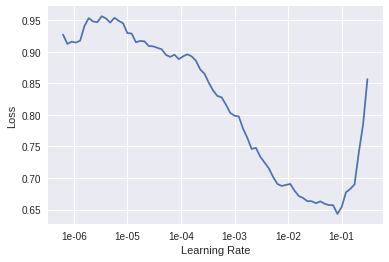

In [47]:
learn.lr_find()
learn.recorder.plot()

In [48]:
learn.fit_one_cycle(5, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.619547,0.361565,0.831126,00:39
1,0.462935,0.235712,0.910596,00:32
2,0.390679,0.189214,0.923841,00:32
3,0.345580,0.186374,0.943709,00:32
4,0.288428,0.172231,0.927152,00:33


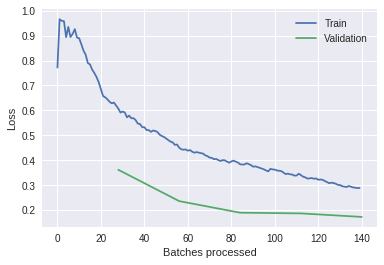

In [49]:
learn.recorder.plot_losses()

Let's train more:

In [50]:
learn.fit_one_cycle(10, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.198429,0.173350,0.927152,00:32
1,0.208632,0.180024,0.930464,00:32
2,0.230857,0.204278,0.933775,00:32
3,0.213982,0.175405,0.930464,00:32
4,0.211533,0.176643,0.930464,00:32
5,0.193075,0.141118,0.943709,00:32
6,0.158908,0.125309,0.950331,00:32
7,0.146980,0.116393,0.956954,00:32
8,0.129993,0.121016,0.963576,00:32
9,0.127540,0.129554,0.953642,00:32


In [52]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.065999,0.122912,0.963576,00:32
1,0.103951,0.131731,0.960265,00:32
2,0.127423,0.117103,0.950331,00:32
3,0.119069,0.173295,0.933775,00:32
4,0.101874,0.125053,0.960265,00:32
5,0.090316,0.126671,0.956954,00:32
6,0.077296,0.125792,0.963576,00:32
7,0.074703,0.131524,0.953642,00:33
8,0.080920,0.131260,0.960265,00:32
9,0.070303,0.126202,0.960265,00:32


In [0]:
learn.save(path+'/polyp-resnet50_ACC-0.96')

I don't like the spike in the graph but the training returned to a good path :-) The current model with **ACC = 0.96** .


Let's see the confusion matrix for *polyp-resnet-50'*:

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [55]:
interp.most_confused(min_val=2)

[('polyps', 'non_polyps', 10), ('non_polyps', 'polyps', 2)]

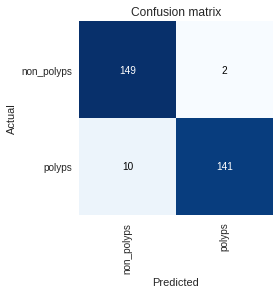

In [56]:
interp.plot_confusion_matrix()

The model is relatively good to not predict polyps where they are not present, but it has some problems in predicting polyps where they are not present.

Let's unfreeze the bottom layers of *resnet50* and train with specific learning rates:

In [57]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.094441,0.166618,0.960265,00:46
1,0.135506,0.379064,0.894040,00:41
2,0.163094,0.208347,0.937086,00:41
3,0.125663,0.142790,0.950331,00:41
4,0.105716,0.132430,0.950331,00:41


In [78]:
learn.load(path+'/polyp-resnet50_ACC-0.96')
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-6,5e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.077920,0.127680,0.960265,00:41
1,0.071741,0.119343,0.956954,00:41
2,0.074366,0.128183,0.966887,00:42
3,0.077885,0.142844,0.953642,00:41
4,0.070179,0.117320,0.963576,00:41


In [79]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.099194,0.226153,0.917219,00:41
1,0.160536,0.567238,0.870861,00:41
2,0.246907,0.299883,0.903974,00:41
3,0.226492,0.183915,0.937086,00:41
4,0.211938,0.130814,0.960265,00:41
5,0.185015,0.124553,0.956954,00:41
6,0.161613,0.118640,0.966887,00:41
7,0.136892,0.088430,0.960265,00:42
8,0.105573,0.071202,0.970199,00:41
9,0.085771,0.065865,0.970199,00:41


In [80]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.084083,0.084765,0.960265,00:41
1,0.079417,0.121279,0.970199,00:41
2,0.151792,0.464385,0.844371,00:41
3,0.222459,0.377730,0.874172,00:41
4,0.241225,0.110140,0.960265,00:41
5,0.215768,0.121924,0.960265,00:42
6,0.171939,0.105247,0.956954,00:42
7,0.144875,0.082641,0.970199,00:42
8,0.118265,0.077934,0.970199,00:41
9,0.111002,0.075159,0.973510,00:41


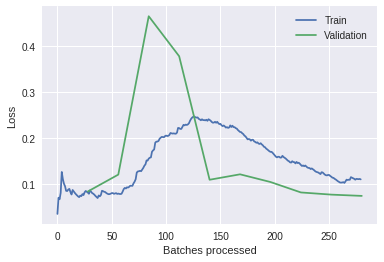

In [81]:
learn.recorder.plot_losses()

Yep, it's a strange plot but the end is fine ;-)

In [0]:
learn.save(path+'/polyp-resnet50-fine-tuning_ACC-0.9735')

In [9]:
learn.load(path+'/polyp-resnet50-fine-tuning_ACC-0.9735')
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.063559,0.073321,0.973510,00:41
1,0.071396,0.087808,0.970199,00:41
2,0.066802,0.109056,0.970199,00:41
3,0.067393,0.076234,0.976821,00:41
4,0.071113,0.096450,0.970199,00:41
5,0.054097,0.086658,0.966887,00:41
6,0.060568,0.076584,0.966887,00:41
7,0.060798,0.068697,0.973510,00:41
8,0.059498,0.071162,0.970199,00:41
9,0.056887,0.069643,0.970199,00:41


In [12]:
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-3/3))

epoch,train_loss,valid_loss,accuracy,time
0,0.043994,0.066923,0.983444,00:41
1,0.046481,0.057681,0.990066,00:41
2,0.034157,0.058616,0.990066,00:41


In [0]:
learn.save(path+'/polyp-resnet50-fine-tuning_ACC-0.99')

**ACC = 0.99** with resnet50 fine tuning!. Let's look at the model details:

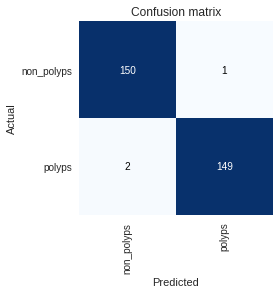

In [30]:
learn.load(path+'/polyp-resnet50-fine-tuning_ACC-0.99')

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [31]:
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

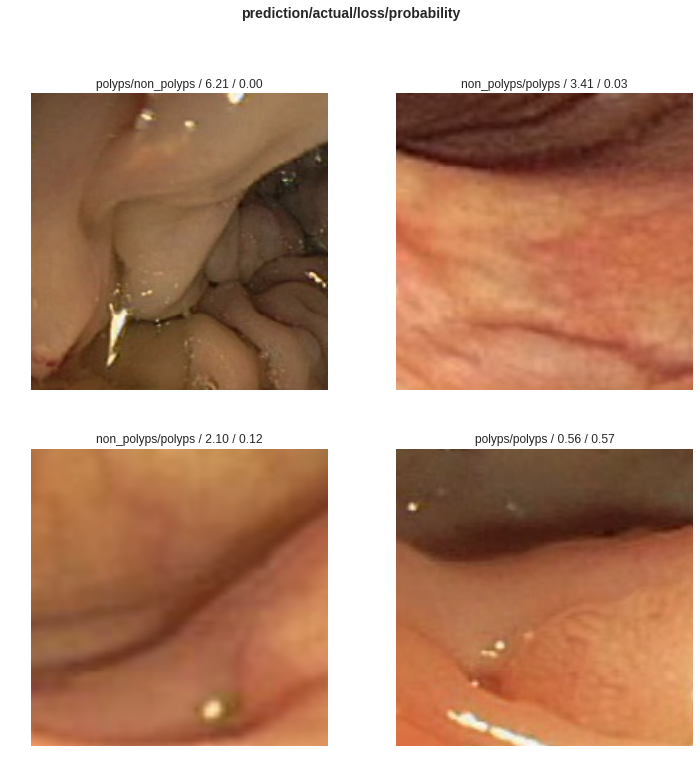

In [36]:
interp.plot_top_losses(4, heatmap=False)

We can observe that the 3 errors from the confusion matrix are generated by extreme light reflexions mixed with distant view (first image).

**Conclusions**: The best model using ACC as metrics was provided by *resnet50* using fine-tuning: **ACC = 0.99**!. As you can see Fastai framework is a fast solution for medical imaging tasks.

[@muntisa](https://sites.google.com/site/muntisa/)